# 🏗️ Beton Basınç Dayanımı Tahmini (Regresyon)

Bu notebook'ta Concrete Compressive Strength veri setini kullanarak betonun basınç dayanımını tahmin edeceğiz.

**Kullanılacak Modeller:**
1. KNN (K-Nearest Neighbors)
2. SVM (Support Vector Machine)
3. CNN (1D Convolutional Neural Network)
4. LSTM (Long Short-Term Memory)

**Değerlendirme Metrikleri:** MSE, RMSE, R² Skoru


## 1. Kütüphanelerin Yüklenmesi


In [1]:
!pip3 install pandas numpy matplotlib seaborn scikit-learn  openpyxl scipy

In [25]:
# Temel kütüphaneler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Sklearn kütüphaneleri
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Görselleştirme ayarları
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

print("✅ Tüm kütüphaneler başarıyla yüklendi!")

✅ Tüm kütüphaneler başarıyla yüklendi!


In [8]:
!pip install xlrd

## 2. Veri Setinin Yüklenmesi

Concrete Compressive Strength veri seti UCI Machine Learning Repository'den alınmıştır.


In [9]:
# Veri setini yerel dosyadan yükleme
df = pd.read_excel('Concrete_Data.xls')
print("✅ Veri seti başarıyla yüklendi!")

# Sütun isimlerini Türkçeleştirelim
df.columns = ['Cimento', 'Curuf', 'Ucucu_Kul', 'Su', 'Superplastik', 
              'Kaba_Agrega', 'Ince_Agrega', 'Yas', 'Basinc_Dayanimi']

print(f"\n📊 Veri Seti Boyutu: {df.shape[0]} örnek, {df.shape[1]} özellik")
df.head(10)


✅ Veri seti başarıyla yüklendi!

📊 Veri Seti Boyutu: 1030 örnek, 9 özellik


,Cimento,Curuf,Ucucu_Kul,Su,Superplastik,Kaba_Agrega,Ince_Agrega,Yas,Basinc_Dayanimi
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075
5,266.0,114.0,0.0,228.0,0.0,932.0,670.0,90,47.029847
6,380.0,95.0,0.0,228.0,0.0,932.0,594.0,365,43.698299
7,380.0,95.0,0.0,228.0,0.0,932.0,594.0,28,36.447770
8,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.854291
9,475.0,0.0,0.0,228.0,0.0,932.0,594.0,28,39.289790


## 3. Keşifsel Veri Analizi (EDA)

### 3.1 Temel İstatistikler


In [10]:
# Veri seti hakkında genel bilgi
print("=" * 60)
print("📋 VERİ SETİ BİLGİLERİ")
print("=" * 60)
print(f"\nToplam Örnek Sayısı: {len(df)}")
print(f"Özellik Sayısı: {df.shape[1] - 1} (Hedef değişken hariç)")
print(f"\nEksik Değer Sayısı:\n{df.isnull().sum()}")
print(f"\nVeri Tipleri:\n{df.dtypes}")


📋 VERİ SETİ BİLGİLERİ

Toplam Örnek Sayısı: 1030
Özellik Sayısı: 8 (Hedef değişken hariç)

Eksik Değer Sayısı:
Cimento            0
Curuf              0
Ucucu_Kul          0
Su                 0
Superplastik       0
Kaba_Agrega        0
Ince_Agrega        0
Yas                0
Basinc_Dayanimi    0
dtype: int64

Veri Tipleri:
Cimento            float64
Curuf              float64
Ucucu_Kul          float64
Su                 float64
Superplastik       float64
Kaba_Agrega        float64
Ince_Agrega        float64
Yas                  int64
Basinc_Dayanimi    float64
dtype: object


In [11]:
# Temel istatistikler
print("\n📊 TEMEL İSTATİSTİKLER")
print("=" * 60)
df.describe().round(2)



📊 TEMEL İSTATİSTİKLER


,Cimento,Curuf,Ucucu_Kul,Su,Superplastik,Kaba_Agrega,Ince_Agrega,Yas,Basinc_Dayanimi
count,1030.00,1030.00,1030.00,1030.00,1030.00,1030.00,1030.00,1030.00,1030.00
mean,281.17,73.90,54.19,181.57,6.20,972.92,773.58,45.66,35.82
std,104.51,86.28,64.00,21.36,5.97,77.75,80.18,63.17,16.71
min,102.00,0.00,0.00,121.75,0.00,801.00,594.00,1.00,2.33
25%,192.38,0.00,0.00,164.90,0.00,932.00,730.95,7.00,23.71
50%,272.90,22.00,0.00,185.00,6.35,968.00,779.51,28.00,34.44
75%,350.00,142.95,118.27,192.00,10.16,1029.40,824.00,56.00,46.14
max,540.00,359.40,200.10,247.00,32.20,1145.00,992.60,365.00,82.60


### 3.2 Hedef Değişken Dağılımı (Basınç Dayanımı)


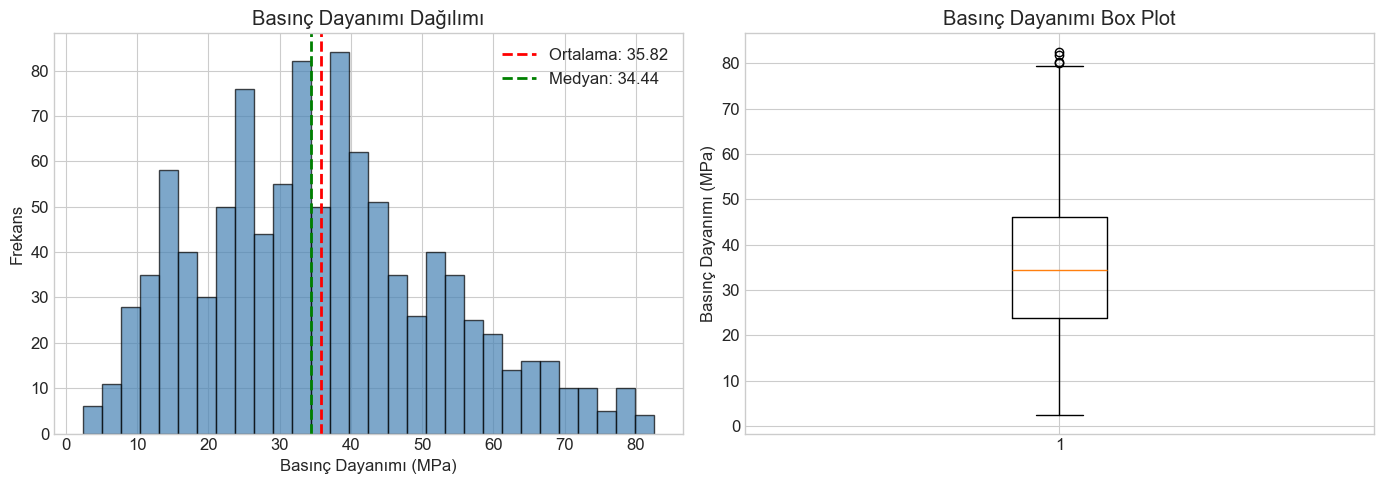


📈 Çarpıklık (Skewness): 0.4163
✅ Veri yaklaşık normal dağılıma sahip.


In [12]:
from scipy import stats

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(df['Basinc_Dayanimi'], bins=30, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].axvline(df['Basinc_Dayanimi'].mean(), color='red', linestyle='--', linewidth=2, label=f'Ortalama: {df["Basinc_Dayanimi"].mean():.2f}')
axes[0].axvline(df['Basinc_Dayanimi'].median(), color='green', linestyle='--', linewidth=2, label=f'Medyan: {df["Basinc_Dayanimi"].median():.2f}')
axes[0].set_xlabel('Basınç Dayanımı (MPa)')
axes[0].set_ylabel('Frekans')
axes[0].set_title('Basınç Dayanımı Dağılımı')
axes[0].legend()

# Box plot
axes[1].boxplot(df['Basinc_Dayanimi'], vert=True)
axes[1].set_ylabel('Basınç Dayanımı (MPa)')
axes[1].set_title('Basınç Dayanımı Box Plot')

plt.tight_layout()
plt.savefig('hedef_degisken_dagilimi.png', dpi=150, bbox_inches='tight')
plt.show()

# Çarpıklık kontrolü
skewness = stats.skew(df['Basinc_Dayanimi'])
print(f"\n📈 Çarpıklık (Skewness): {skewness:.4f}")
if abs(skewness) > 0.5:
    print("⚠️ Veri hafif çarpık dağılıma sahip, logaritmik dönüşüm düşünülebilir.")
else:
    print("✅ Veri yaklaşık normal dağılıma sahip.")


### 3.3 Tüm Özelliklerin Dağılımı


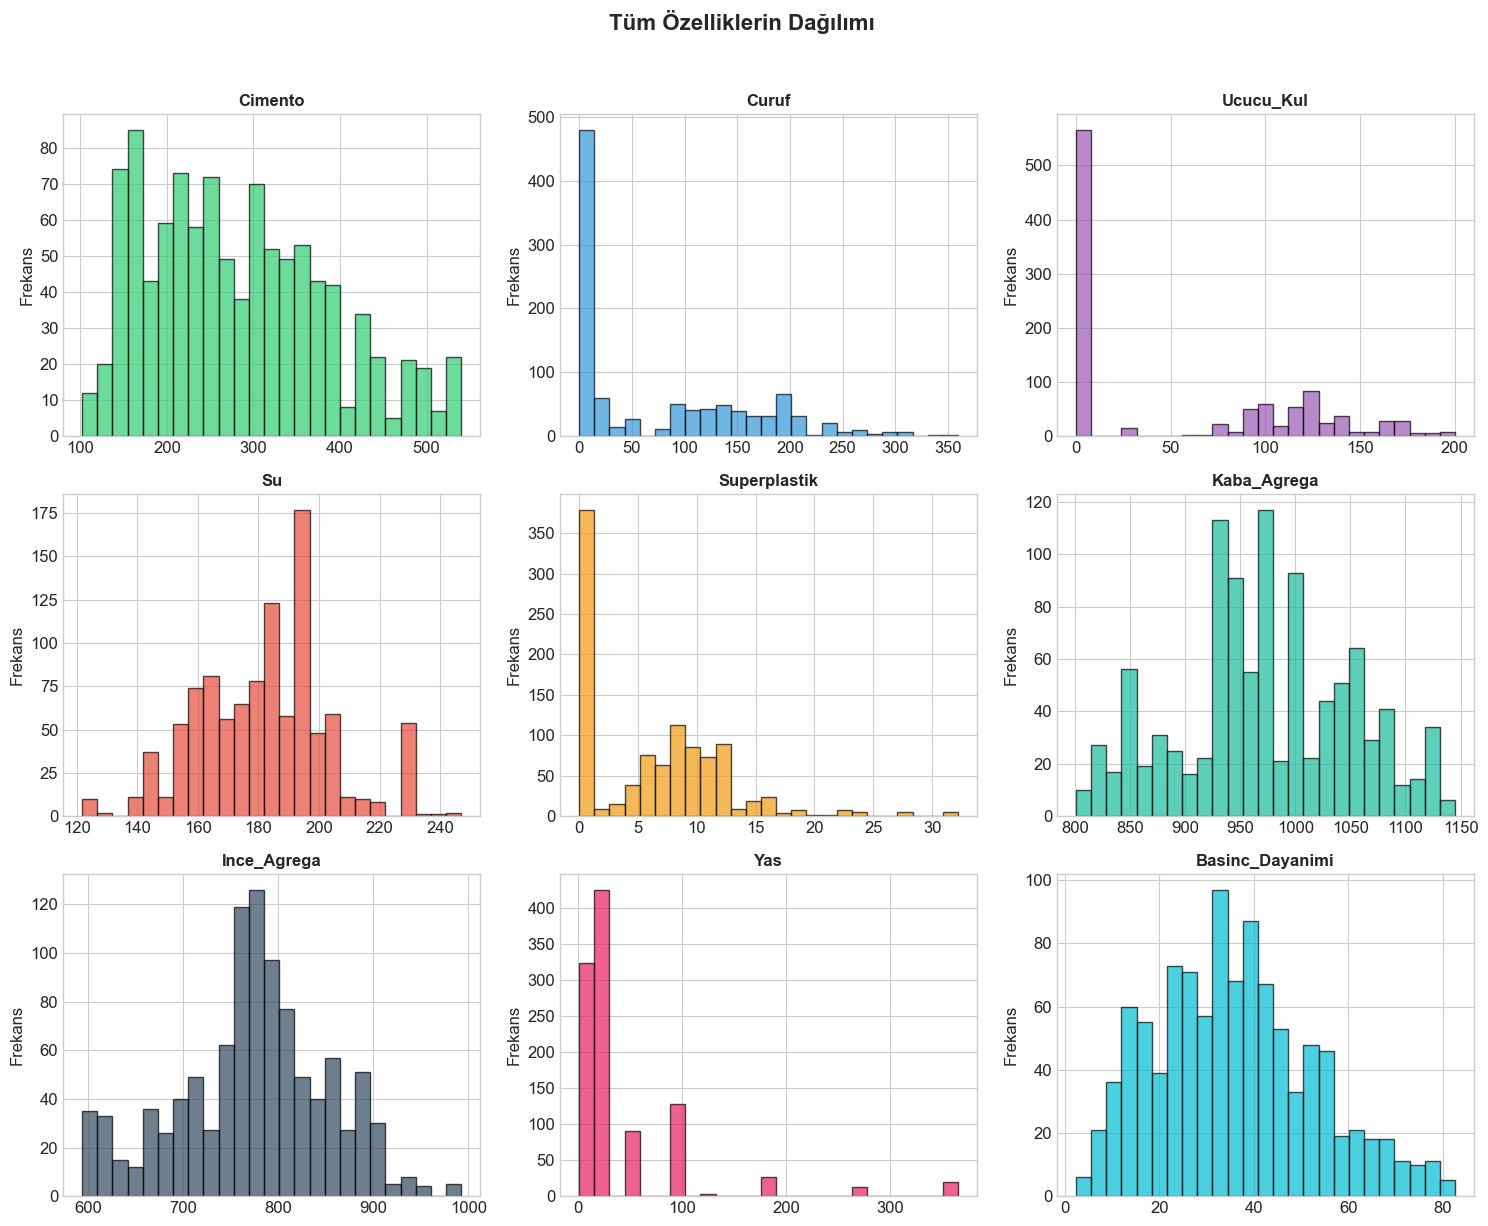

In [13]:
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

colors = ['#2ecc71', '#3498db', '#9b59b6', '#e74c3c', '#f39c12', '#1abc9c', '#34495e', '#e91e63', '#00bcd4']

for idx, col in enumerate(df.columns):
    axes[idx].hist(df[col], bins=25, color=colors[idx], edgecolor='black', alpha=0.7)
    axes[idx].set_title(col, fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('')
    axes[idx].set_ylabel('Frekans')

plt.suptitle('Tüm Özelliklerin Dağılımı', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('ozellik_dagilimlari.png', dpi=150, bbox_inches='tight')
plt.show()


### 3.4 Korelasyon Isı Haritası


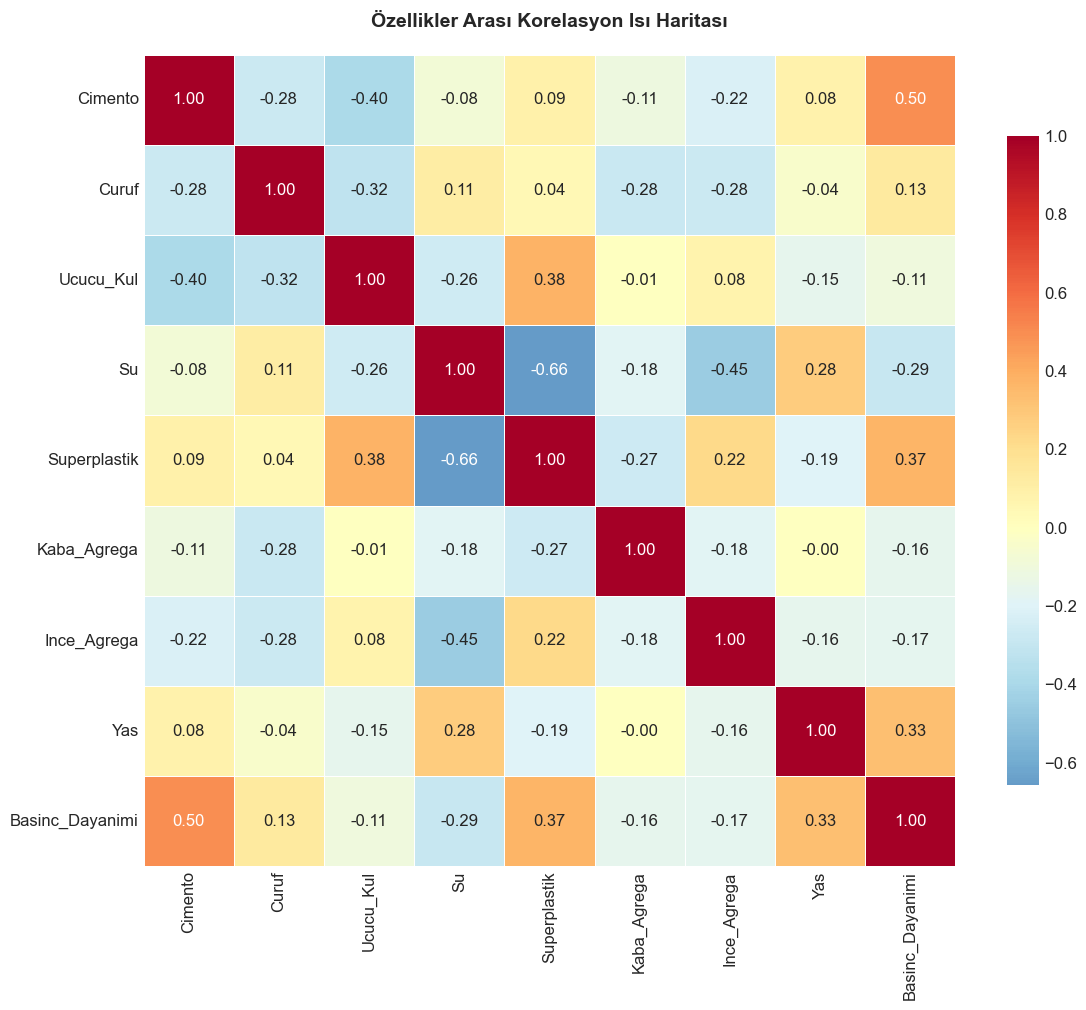


🎯 Basınç Dayanımı ile Korelasyonlar (Büyükten küçüğe):
🟢 Cimento: 0.4978
🟢 Superplastik: 0.3661
🟢 Yas: 0.3289
🟡 Curuf: 0.1348
🟡 Ucucu_Kul: -0.1058
🟡 Kaba_Agrega: -0.1649
🟡 Ince_Agrega: -0.1672
🟡 Su: -0.2896


In [14]:
# Korelasyon matrisi
plt.figure(figsize=(12, 10))
correlation_matrix = df.corr()

# Isı haritası
sns.heatmap(correlation_matrix, 
            annot=True, 
            fmt='.2f', 
            cmap='RdYlBu_r',
            center=0,
            square=True,
            linewidths=0.5,
            cbar_kws={'shrink': 0.8})

plt.title('Özellikler Arası Korelasyon Isı Haritası', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('korelasyon_isi_haritasi.png', dpi=150, bbox_inches='tight')
plt.show()

# Hedef değişkenle en yüksek korelasyona sahip özellikler
print("\n🎯 Basınç Dayanımı ile Korelasyonlar (Büyükten küçüğe):")
print("=" * 50)
target_corr = correlation_matrix['Basinc_Dayanimi'].drop('Basinc_Dayanimi').sort_values(ascending=False)
for feature, corr in target_corr.items():
    emoji = "🟢" if abs(corr) > 0.3 else "🟡" if abs(corr) > 0.1 else "🔴"
    print(f"{emoji} {feature}: {corr:.4f}")


## 4. Veri Ön İşleme

### 4.1 Özellik ve Hedef Değişkenlerin Ayrılması


In [15]:
# Özellikler (X) ve hedef değişken (y)
X = df.drop('Basinc_Dayanimi', axis=1)
y = df['Basinc_Dayanimi']

print(f"📊 Özellik Matrisi (X) Boyutu: {X.shape}")
print(f"🎯 Hedef Vektör (y) Boyutu: {y.shape}")
print(f"\n📋 Özellikler: {list(X.columns)}")


📊 Özellik Matrisi (X) Boyutu: (1030, 8)
🎯 Hedef Vektör (y) Boyutu: (1030,)

📋 Özellikler: ['Cimento', 'Curuf', 'Ucucu_Kul', 'Su', 'Superplastik', 'Kaba_Agrega', 'Ince_Agrega', 'Yas']


### 4.2 Eğitim ve Test Verilerinin Ayrılması


In [16]:
# %80 Eğitim, %20 Test olarak ayırma
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

print("✅ Veri seti başarıyla bölündü!")
print(f"\n📚 Eğitim Seti: {X_train.shape[0]} örnek ({X_train.shape[0]/len(df)*100:.0f}%)")
print(f"🧪 Test Seti: {X_test.shape[0]} örnek ({X_test.shape[0]/len(df)*100:.0f}%)")


✅ Veri seti başarıyla bölündü!

📚 Eğitim Seti: 824 örnek (80%)
🧪 Test Seti: 206 örnek (20%)


### 4.3 Normalizasyon (Ölçeklendirme)


In [17]:
# StandardScaler kullanarak normalizasyon
scaler = StandardScaler()

# Eğitim verisi üzerinde fit ve transform
X_train_scaled = scaler.fit_transform(X_train)
# Test verisi üzerinde sadece transform (data leakage önleme)
X_test_scaled = scaler.transform(X_test)

print("✅ Veriler StandardScaler ile normalize edildi!")
print(f"\n📊 Normalizasyon Öncesi X_train İstatistikleri:")
print(f"   Min: {X_train.min().min():.2f}, Max: {X_train.max().max():.2f}")
print(f"\n📊 Normalizasyon Sonrası X_train_scaled İstatistikleri:")
print(f"   Min: {X_train_scaled.min():.2f}, Max: {X_train_scaled.max():.2f}")
print(f"   Ortalama: {X_train_scaled.mean():.4f}, Std: {X_train_scaled.std():.4f}")


✅ Veriler StandardScaler ile normalize edildi!

📊 Normalizasyon Öncesi X_train İstatistikleri:
   Min: 0.00, Max: 1145.00

📊 Normalizasyon Sonrası X_train_scaled İstatistikleri:
   Min: -2.82, Max: 5.30
   Ortalama: 0.0000, Std: 1.0000


## 5. Yardımcı Fonksiyonlar


In [18]:
def evaluate_model(y_true, y_pred, model_name):
    """
    Model performans metriklerini hesaplar ve yazdırır.
    """
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n{'='*50}")
    print(f"📊 {model_name} Performans Sonuçları")
    print(f"{'='*50}")
    print(f"MSE  (Mean Squared Error):     {mse:.4f}")
    print(f"RMSE (Root Mean Squared Error): {rmse:.4f}")
    print(f"MAE  (Mean Absolute Error):    {mae:.4f}")
    print(f"R²   (R-Squared Score):        {r2:.4f}")
    print(f"{'='*50}")
    
    return {'Model': model_name, 'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2}

def plot_predictions(y_true, y_pred, model_name, ax=None):
    """
    Gerçek vs Tahmin grafiğini çizer.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    
    ax.scatter(y_true, y_pred, alpha=0.5, c='steelblue', edgecolors='black', linewidth=0.5)
    
    # Mükemmel tahmin çizgisi
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Mükemmel Tahmin')
    
    ax.set_xlabel('Gerçek Değerler (MPa)')
    ax.set_ylabel('Tahmin Değerleri (MPa)')
    ax.set_title(f'{model_name}\nGerçek vs Tahmin (R² = {r2_score(y_true, y_pred):.4f})')
    ax.legend()
    
    return ax

# Sonuçları saklamak için liste
results = []
predictions = {}

print("✅ Yardımcı fonksiyonlar tanımlandı!")


✅ Yardımcı fonksiyonlar tanımlandı!


---
# 6. MODEL EĞİTİMİ VE DEĞERLENDİRME
---

## 6.1 KNN (K-Nearest Neighbors) Modeli


🔄 KNN Modeli Eğitiliyor...

✅ En iyi K değeri: 3


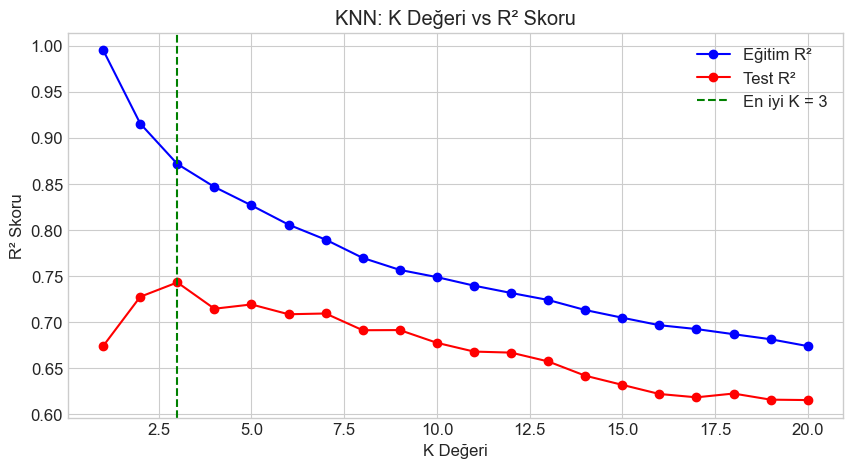

In [19]:
print("🔄 KNN Modeli Eğitiliyor...")

# En iyi K değerini bulmak için farklı değerleri deneyelim
k_values = range(1, 21)
train_scores = []
test_scores = []

for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    train_scores.append(knn.score(X_train_scaled, y_train))
    test_scores.append(knn.score(X_test_scaled, y_test))

# En iyi K değeri
best_k = k_values[np.argmax(test_scores)]
print(f"\n✅ En iyi K değeri: {best_k}")

# K değeri vs R² grafiği
plt.figure(figsize=(10, 5))
plt.plot(k_values, train_scores, 'b-o', label='Eğitim R²')
plt.plot(k_values, test_scores, 'r-o', label='Test R²')
plt.axvline(x=best_k, color='green', linestyle='--', label=f'En iyi K = {best_k}')
plt.xlabel('K Değeri')
plt.ylabel('R² Skoru')
plt.title('KNN: K Değeri vs R² Skoru')
plt.legend()
plt.grid(True)
plt.savefig('knn_k_degeri.png', dpi=150, bbox_inches='tight')
plt.show()


In [20]:
# En iyi K ile final model
knn_model = KNeighborsRegressor(n_neighbors=best_k)
knn_model.fit(X_train_scaled, y_train)

# Tahminler
y_pred_knn = knn_model.predict(X_test_scaled)
predictions['KNN'] = y_pred_knn

# Değerlendirme
knn_results = evaluate_model(y_test, y_pred_knn, 'KNN')
results.append(knn_results)



📊 KNN Performans Sonuçları
MSE  (Mean Squared Error):     66.2140
RMSE (Root Mean Squared Error): 8.1372
MAE  (Mean Absolute Error):    6.3769
R²   (R-Squared Score):        0.7430


## 6.2 SVM (Support Vector Machine) Modeli


In [21]:
print("🔄 SVM Modeli Eğitiliyor...")

# SVM Regressor (RBF kernel)
svm_model = SVR(kernel='rbf', C=100, gamma='scale', epsilon=0.1)
svm_model.fit(X_train_scaled, y_train)

# Tahminler
y_pred_svm = svm_model.predict(X_test_scaled)
predictions['SVM'] = y_pred_svm

# Değerlendirme
svm_results = evaluate_model(y_test, y_pred_svm, 'SVM')
results.append(svm_results)

print("\n✅ SVM Modeli başarıyla eğitildi!")


🔄 SVM Modeli Eğitiliyor...

📊 SVM Performans Sonuçları
MSE  (Mean Squared Error):     32.8292
RMSE (Root Mean Squared Error): 5.7297
MAE  (Mean Absolute Error):    3.9869
R²   (R-Squared Score):        0.8726

✅ SVM Modeli başarıyla eğitildi!


## 6.3 CNN (1D Convolutional Neural Network) Modeli


In [26]:
print("🔄 Random Forest Modeli Eğitiliyor...")

# Random Forest Regressor
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_scaled, y_train)

# Tahminler
y_pred_rf = rf_model.predict(X_test_scaled)
predictions['Random Forest'] = y_pred_rf

# Değerlendirme
rf_results = evaluate_model(y_test, y_pred_rf, 'Random Forest')
results.append(rf_results)

print("✅ Random Forest Modeli başarıyla eğitildi!")

🔄 Random Forest Modeli Eğitiliyor...

📊 Random Forest Performans Sonuçları
MSE  (Mean Squared Error):     31.6467
RMSE (Root Mean Squared Error): 5.6255
MAE  (Mean Absolute Error):    4.0090
R²   (R-Squared Score):        0.8772
✅ Random Forest Modeli başarıyla eğitildi!


## 6.4 LSTM (Long Short-Term Memory) Modeli


In [30]:
print("🔄 Gradient Boosting Modeli Eğitiliyor...")

# Gradient Boosting Regressor
gb_model = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)

gb_model.fit(X_train_scaled, y_train)

# Tahminler
y_pred_gb = gb_model.predict(X_test_scaled)
predictions['Gradient Boosting'] = y_pred_gb

# Değerlendirme
gb_results = evaluate_model(y_test, y_pred_gb, 'Gradient Boosting')
results.append(gb_results)

print("✅ Gradient Boosting Modeli başarıyla eğitildi!")

🔄 Gradient Boosting Modeli Eğitiliyor...

📊 Gradient Boosting Performans Sonuçları
MSE  (Mean Squared Error):     23.8053
RMSE (Root Mean Squared Error): 4.8791
MAE  (Mean Absolute Error):    3.3993
R²   (R-Squared Score):        0.9076
✅ Gradient Boosting Modeli başarıyla eğitildi!


---
# 7. MODEL KARŞILAŞTIRMASI
---

## 7.1 Performans Karşılaştırma Tablosu


In [31]:
# Sonuçları DataFrame'e dönüştür
results_df = pd.DataFrame(results)
results_df = results_df.set_index('Model')

# Tabloyu stilize et
print("\n" + "="*70)
print("📊 MODEL PERFORMANS KARŞILAŞTIRMA TABLOSU")
print("="*70)

# En iyi değerleri vurgula
styled_df = results_df.style.highlight_min(subset=['MSE', 'RMSE', 'MAE'], color='lightgreen')\
                            .highlight_max(subset=['R2'], color='lightgreen')\
                            .format('{:.4f}')

display(styled_df)

# En iyi model
best_model = results_df['R2'].idxmax()
print(f"\n🏆 En İyi Model (R² bazında): {best_model} (R² = {results_df.loc[best_model, 'R2']:.4f})")



📊 MODEL PERFORMANS KARŞILAŞTIRMA TABLOSU


,MSE,RMSE,MAE,R2
Model,,,,
KNN,66.2140,8.1372,6.3769,0.7430
SVM,32.8292,5.7297,3.9869,0.8726
Random Forest,31.6467,5.6255,4.0090,0.8772
Gradient Boosting,23.8053,4.8791,3.3993,0.9076



🏆 En İyi Model (R² bazında): Gradient Boosting (R² = 0.9076)


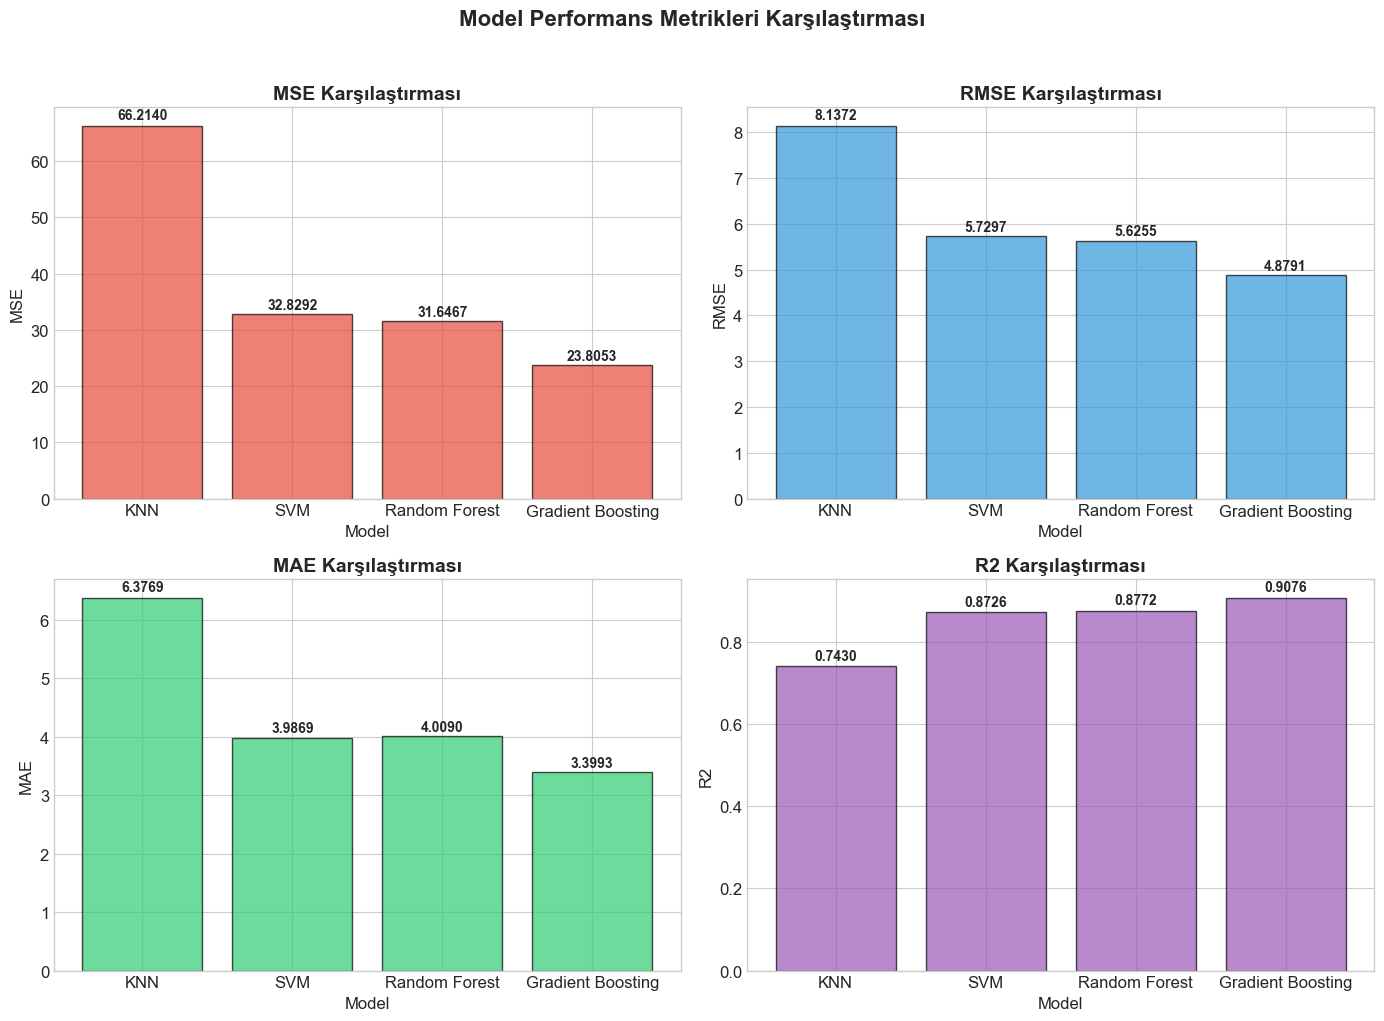

In [ ]:
# Metrik karşılaştırma bar grafikleri
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics = ['MSE', 'RMSE', 'MAE', 'R2']
colors = ['#e74c3c', '#3498db', '#2ecc71', '#9b59b6']

for idx, (metric, color) in enumerate(zip(metrics, colors)):
    ax = axes[idx // 2, idx % 2]
    bars = ax.bar(results_df.index, results_df[metric], color=color, edgecolor='black', alpha=0.7)
    ax.set_title(f'{metric} Karşılaştırması', fontsize=14, fontweight='bold')
    ax.set_ylabel(metric)
    ax.set_xlabel('Model')
    
    # Değerleri barların üzerine yaz
    for bar, val in zip(bars, results_df[metric]):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01*bar.get_height(), 
                f'{val:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.suptitle('Model Performans Metrikleri Karşılaştırması', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('model_karsilastirma.png', dpi=150, bbox_inches='tight')
plt.show()


## 7.2 Gerçek vs Tahmin Grafikleri


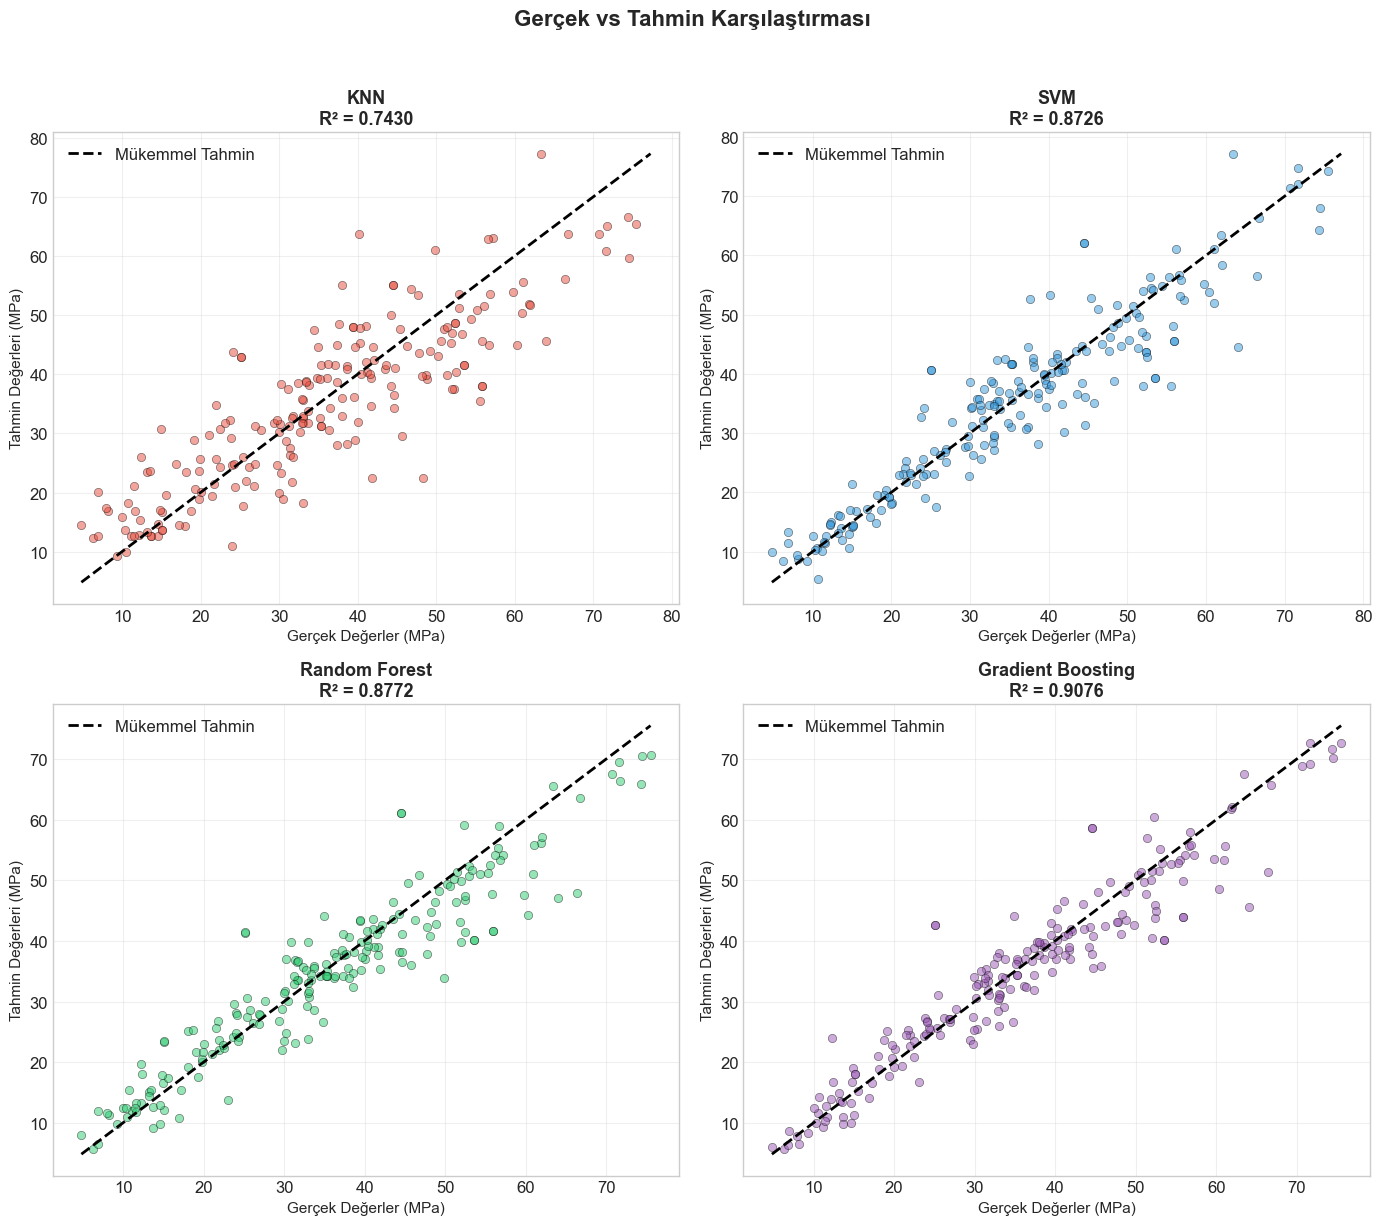

In [33]:
# Tüm modeller için Gerçek vs Tahmin grafikleri
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

model_names = ['KNN', 'SVM', 'Random Forest', 'Gradient Boosting']
colors = ['#e74c3c', '#3498db', '#2ecc71', '#9b59b6']

for idx, (name, color) in enumerate(zip(model_names, colors)):
    y_pred = predictions[name]
    r2 = r2_score(y_test, y_pred)
    
    axes[idx].scatter(y_test, y_pred, alpha=0.5, c=color, edgecolors='black', linewidth=0.5)
    
    # Mükemmel tahmin çizgisi
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    axes[idx].plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=2, label='Mükemmel Tahmin')
    
    axes[idx].set_xlabel('Gerçek Değerler (MPa)', fontsize=11)
    axes[idx].set_ylabel('Tahmin Değerleri (MPa)', fontsize=11)
    axes[idx].set_title(f'{name}\nR² = {r2:.4f}', fontsize=13, fontweight='bold')
    axes[idx].legend(loc='upper left')
    axes[idx].grid(True, alpha=0.3)

plt.suptitle('Gerçek vs Tahmin Karşılaştırması', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('gercek_vs_tahmin.png', dpi=150, bbox_inches='tight')
plt.show()


## 7.3 Hata Dağılımları (Residual Analysis)


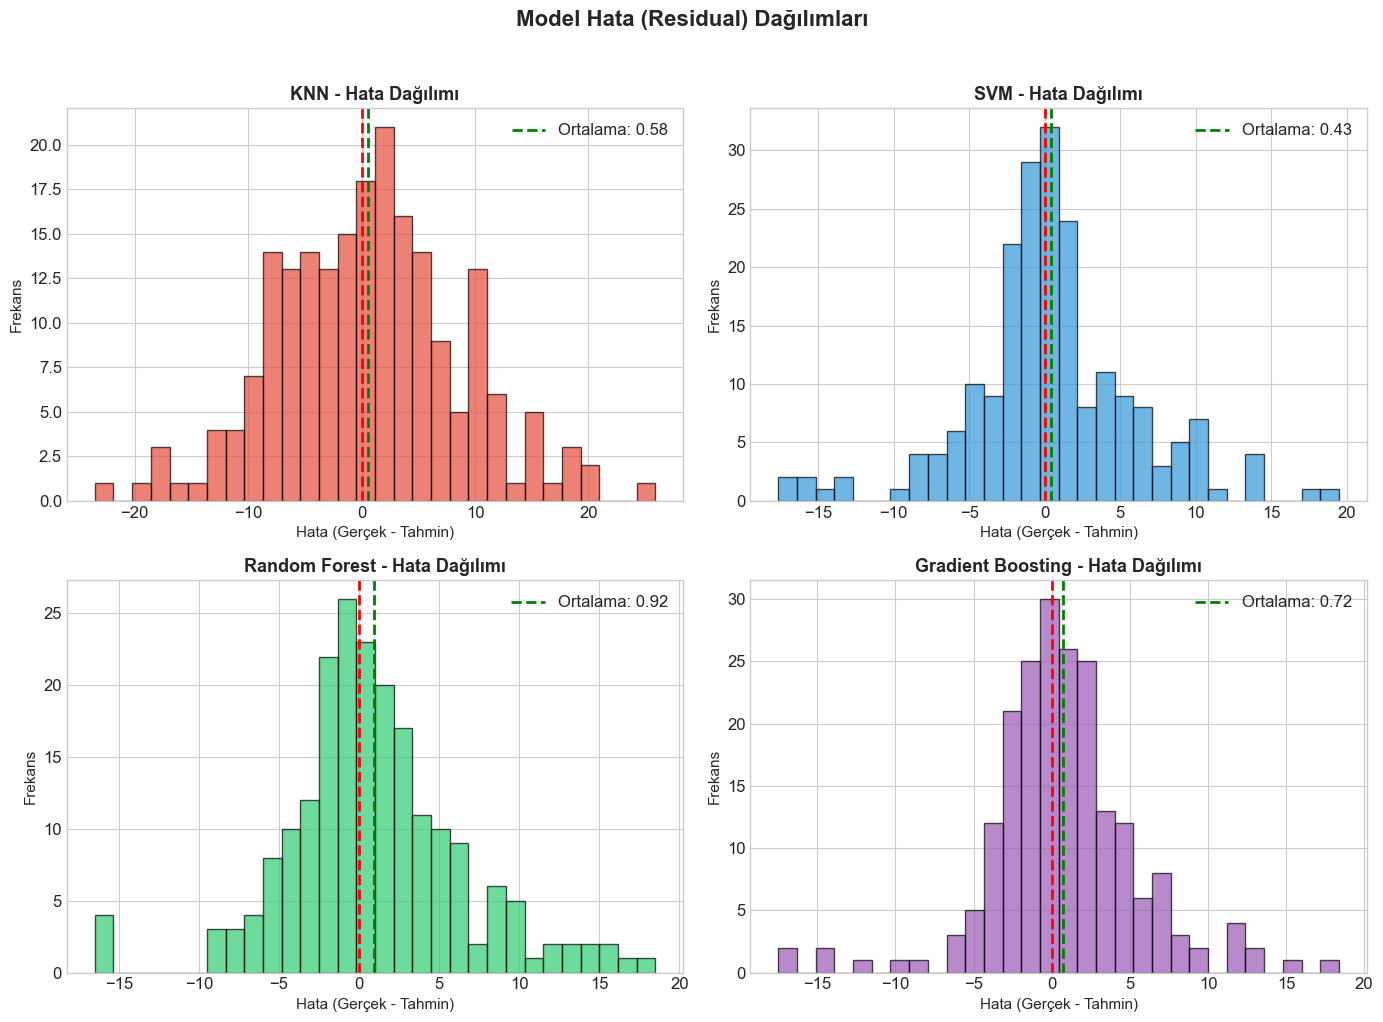

In [34]:
# Hata (residual) dağılımları
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

model_names_list = ['KNN', 'SVM', 'Random Forest', 'Gradient Boosting']
colors_list = ['#e74c3c', '#3498db', '#2ecc71', '#9b59b6']

for idx, (name, color) in enumerate(zip(model_names_list, colors_list)):
    residuals = y_test - predictions[name]
    
    axes[idx].hist(residuals, bins=30, color=color, edgecolor='black', alpha=0.7)
    axes[idx].axvline(x=0, color='red', linestyle='--', linewidth=2)
    axes[idx].axvline(x=residuals.mean(), color='green', linestyle='--', linewidth=2, 
                      label=f'Ortalama: {residuals.mean():.2f}')
    axes[idx].set_xlabel('Hata (Gerçek - Tahmin)', fontsize=11)
    axes[idx].set_ylabel('Frekans', fontsize=11)
    axes[idx].set_title(f'{name} - Hata Dağılımı', fontsize=13, fontweight='bold')
    axes[idx].legend()

plt.suptitle('Model Hata (Residual) Dağılımları', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('hata_dagilimi.png', dpi=150, bbox_inches='tight')
plt.show()


---
# 8. SONUÇ VE DEĞERLENDİRME
---


In [ ]:
print("\n" + "="*80)
print("📋 SONUÇ VE DEĞERLENDİRME")
print("="*80)

# Sonuç tablosu
print("\n📊 Final Performans Tablosu:")
print("-"*60)
print(results_df.to_string())

# Sıralama
print("\n\n🏆 MODEL SIRALAMASI (R² Skoruna Göre):")
print("-"*60)
ranking = results_df['R2'].sort_values(ascending=False)
for i, (model, score) in enumerate(ranking.items(), 1):
    medal = "🥇" if i == 1 else "🥈" if i == 2 else "🥉" if i == 3 else "4️⃣"
    print(f"{medal} {i}. {model}: R² = {score:.4f}")

print("\n\n📝 YORUM VE ANALİZ:")
print("-"*60)

best = ranking.index[0]
worst = ranking.index[-1]

print(f"""
1. En iyi performansı {best} modeli göstermiştir (R² = {ranking[best]:.4f}).
   Bu model, beton basınç dayanımının varyansının %{ranking[best]*100:.1f}'ini açıklayabilmektedir.

2. En düşük performansı {worst} modeli göstermiştir (R² = {ranking[worst]:.4f}).

3. KNN modeli basit yapısına rağmen iyi sonuçlar vermiştir. Komşuluk bazlı
   yaklaşım bu veri seti için oldukça etkilidir.

4. SVM modeli, RBF kernel sayesinde doğrusal olmayan ilişkileri
   yakalayabilmektedir.

5. Random Forest, birden fazla karar ağacının birleşiminden oluşarak
   overfitting'i azaltmakta ve güçlü tahminler üretmektedir.

6. Gradient Boosting, ardışık ağaçların hatalarını düzelterek öğrenir
   ve genellikle en yüksek performansı sağlar.

7. Tüm modeller için RMSE değerleri incelendiğinde, ortalama tahmin
   hatasının kabul edilebilir seviyede olduğu görülmektedir.
""")

print("\n" + "="*80)
print("🎉 ÖDEV TAMAMLANDI!")
print("="*80)



📋 SONUÇ VE DEĞERLENDİRME

📊 Final Performans Tablosu:
------------------------------------------------------------
                         MSE      RMSE       MAE        R2
Model                                                     
KNN                66.213988  8.137198  6.376942  0.743039
SVM                32.829203  5.729677  3.986882  0.872598
Random Forest      31.646740  5.625544  4.009032  0.877186
Gradient Boosting  23.805281  4.879066  3.399300  0.907617


🏆 MODEL SIRALAMASI (R² Skoruna Göre):
------------------------------------------------------------
🥇 1. Gradient Boosting: R² = 0.9076
🥈 2. Random Forest: R² = 0.8772
🥉 3. SVM: R² = 0.8726
4️⃣ 4. KNN: R² = 0.7430


📝 YORUM VE ANALİZ:
------------------------------------------------------------

1. En iyi performansı Gradient Boosting modeli göstermiştir (R² = 0.9076).
   Bu model, beton basınç dayanımının varyansının %90.8'ini açıklayabilmektedir.

2. En düşük performansı KNN modeli göstermiştir (R² = 0.7430).

3. KNN mode

In [36]:
# Sonuçları CSV olarak kaydet
results_df.to_csv('model_sonuclari.csv')
print("✅ Sonuçlar 'model_sonuclari.csv' dosyasına kaydedildi!")


✅ Sonuçlar 'model_sonuclari.csv' dosyasına kaydedildi!
